In [1]:
import pandas as pd
import numpy as np

In [2]:
val_dataset_df = pd.read_csv("./coco-2014/dataset_csv/val_dataset.csv")
val_dataset_df.head()

,file_name,file_path,height,width,image_id,caption
0,COCO_val2014_000000005802.jpg,/home/harsh/fiftyone/coco-2014/validation/data...,479,640,5802,Two men wearing aprons working in a commercial...
1,COCO_val2014_000000005802.jpg,/home/harsh/fiftyone/coco-2014/validation/data...,479,640,5802,Chefs preparing food in a professional metalli...
2,COCO_val2014_000000005802.jpg,/home/harsh/fiftyone/coco-2014/validation/data...,479,640,5802,Two people standing around in a large kitchen.
3,COCO_val2014_000000005802.jpg,/home/harsh/fiftyone/coco-2014/validation/data...,479,640,5802,A commercial kitchen with two men working to p...
4,COCO_val2014_000000005802.jpg,/home/harsh/fiftyone/coco-2014/validation/data...,479,640,5802,two men in white shirts in a large steel kitchen


In [3]:
test_dataset_df = pd.read_csv('./coco-2014/dataset_csv/test_dataset.csv')
test_list_image_paths = np.random.choice(test_dataset_df['file_path'].values, size=20)
test_list_image_paths

array(['/home/harsh/fiftyone/coco-2014/test/data/COCO_test2014_000000000979.jpg',
       '/home/harsh/fiftyone/coco-2014/test/data/COCO_test2014_000000000660.jpg',
       '/home/harsh/fiftyone/coco-2014/test/data/COCO_test2014_000000005976.jpg',
       '/home/harsh/fiftyone/coco-2014/test/data/COCO_test2014_000000001461.jpg',
       '/home/harsh/fiftyone/coco-2014/test/data/COCO_test2014_000000004522.jpg',
       '/home/harsh/fiftyone/coco-2014/test/data/COCO_test2014_000000003492.jpg',
       '/home/harsh/fiftyone/coco-2014/test/data/COCO_test2014_000000004121.jpg',
       '/home/harsh/fiftyone/coco-2014/test/data/COCO_test2014_000000001634.jpg',
       '/home/harsh/fiftyone/coco-2014/test/data/COCO_test2014_000000002196.jpg',
       '/home/harsh/fiftyone/coco-2014/test/data/COCO_test2014_000000005877.jpg',
       '/home/harsh/fiftyone/coco-2014/test/data/COCO_test2014_000000003620.jpg',
       '/home/harsh/fiftyone/coco-2014/test/data/COCO_test2014_000000001492.jpg',
       '/home/ha

In [4]:
val_list_image_paths = np.random.choice(val_dataset_df['file_path'].values, size=20)
val_list_image_paths

array(['/home/harsh/fiftyone/coco-2014/validation/data/COCO_val2014_000000003501.jpg',
       '/home/harsh/fiftyone/coco-2014/validation/data/COCO_val2014_000000004795.jpg',
       '/home/harsh/fiftyone/coco-2014/validation/data/COCO_val2014_000000004256.jpg',
       '/home/harsh/fiftyone/coco-2014/validation/data/COCO_val2014_000000000074.jpg',
       '/home/harsh/fiftyone/coco-2014/validation/data/COCO_val2014_000000005601.jpg',
       '/home/harsh/fiftyone/coco-2014/validation/data/COCO_val2014_000000001869.jpg',
       '/home/harsh/fiftyone/coco-2014/validation/data/COCO_val2014_000000005754.jpg',
       '/home/harsh/fiftyone/coco-2014/validation/data/COCO_val2014_000000002988.jpg',
       '/home/harsh/fiftyone/coco-2014/validation/data/COCO_val2014_000000002923.jpg',
       '/home/harsh/fiftyone/coco-2014/validation/data/COCO_val2014_000000002867.jpg',
       '/home/harsh/fiftyone/coco-2014/validation/data/COCO_val2014_000000000785.jpg',
       '/home/harsh/fiftyone/coco-2014/vali

# Inference and Evaluation

In [5]:
import os
import sys

import torch
from transformers import Dinov2Config, TrainingArguments, Trainer

from dataset import InferenceDataset
from image_model.image_model import load_image_model
from tokenizer import load_tokenizer
from utils import (
    get_huggingface_trainer_config,
    get_showandtell_gpt2_model_config,
    read_yaml,
    make_dir,
    get_split_config,
    get_tokenizer_config,
    get_dataset_config,
    get_model_config,
    get_inference_dataset_config,
    get_image_model_config,
    get_text_model_config,
)
from showandtell_gpt2.showandtell_gpt2_model import (
    load_showandtell_gpt2,
    load_pretrained_gpt2_model,
)
from model import to_device

In [6]:
config = read_yaml("./showandtell_gpt2/configs/inference_config_clip_vision.yaml")

In [7]:
description, image_paths, dataset_config = get_inference_dataset_config(config)
dataset_config

{'return_dict': True, 'return_tensors': 'pt', 'image_size': [224, 224]}

In [8]:
inference_dataset = InferenceDataset(image_paths, **dataset_config)
inference_dataloader = torch.utils.data.DataLoader(inference_dataset, batch_size=1)
outs = next(iter(inference_dataloader))

In [9]:
tokenizer_name, tokenizer_path, tokenizer_config = get_tokenizer_config(config)
tokenizer = load_tokenizer(
    tokenizer_name=tokenizer_name,
    tokenizer_path=tokenizer_path,
    tokenizer_config=tokenizer_config,
)

In [10]:
# Initialize Models
model_config = get_model_config(config)
model_config

{'showandtell_model': {'model_name': 'showandtell',
  'model_path': '/home/harsh/Desktop/Projects/PaperImplementations/ShowAndTell/showandtell_gpt2/TrainingLogs/runs/clip_gpt2_fulltraining_init/checkpoint-3600/pytorch_model.bin',
  'generation_config': {'temperature': 0.7,
   'num_beams': 10,
   'do_sample': True}},
 'image_model': {'model_name': 'clipvision'},
 'text_model': {'model_name': 'gpt2', 'config': {'add_cross_attention': True}}}

In [11]:
# Image encoder initialization
image_model_name, image_model_path, freeze, image_model_config, kwargs = (
    get_image_model_config(model_config)
)
image_model_name, image_model_path, freeze, image_model_config, kwargs

('clipvision', None, True, {}, {})

In [12]:
image_encoder = load_image_model(
    image_model_name, image_model_config, freeze, image_model_path, **kwargs
)

In [13]:
# [i.requires_grad for i in image_encoder.parameters()]

In [14]:
# from PIL import Image
# import requests
# from transformers import CLIPVisionModelWithProjection, CLIPImageProcessor
# from torch.nn.functional import cross_entropy

# import torch

# url = "http://images.cocodataset.org/val2017/000000039769.jpg"
# image = Image.open(requests.get(url, stream=True).raw)
# processor = CLIPImageProcessor.from_pretrained('openai/clip-vit-base-patch32')
# inputs = processor.preprocess(
#     images=image,
#     return_tensors="pt",
# )
# inputs.keys()
# # processor
# # outs = image_encoder(inputs['pixel_values'].to(device='cuda'))
# # outs[1].shape

In [15]:
# Text encoder initialization
text_model_name, text_model_path, text_model_config = get_text_model_config(
    model_config
)
text_model_config.update(
    {
        "bos_token_id": tokenizer.bos_token_id,
        "eos_token_id": tokenizer.eos_token_id,
        "pad_token_id": tokenizer.pad_token_id,
        "vocab_size": len(tokenizer),
    }
)
gpt2_text_encoder = load_pretrained_gpt2_model(
    text_model_path,
    ignore_mismatched_sizes=True,
    use_safetensors=True,
    **text_model_config,
)

# Combined model initialization (Show and Tell)
(
    showandtell_gpt2_core_model_name,
    showandtell_gpt2_core_model_path,
    showandtell_gpt2_core_config,
) = get_showandtell_gpt2_model_config(model_config)
showandtell_gpt2_core_config

{'generation_config': {'temperature': 0.7, 'num_beams': 10, 'do_sample': True}}

In [16]:
showandtell_gpt2 = to_device(
    load_showandtell_gpt2(
        tokenizer,
        image_encoder,
        gpt2_text_encoder,
        pretrained_model_path=showandtell_gpt2_core_model_path,
        **showandtell_gpt2_core_config,
    ),
    "cuda:0",
)
gpt2_text_encoder.config.use_cache

True

In [17]:
captions = []
with torch.no_grad():
    for batch in inference_dataloader:
        pixel_values = to_device(batch['pixel_values'], 'cuda:0')
        generated_tokens = showandtell_gpt2.generate(pixel_values)
        decoded_text = tokenizer.batch_decode(
            generated_tokens, skip_special_tokens=True
        )[0]
        captions.append(decoded_text)

In [18]:
generated_tokens

tensor([[50258,   317,  1341,   959,   326,   318,  5055,   287,   262,  6729,
           319,  1353,   286,   257, 12788,    13,   220, 50256]],
       device='cuda:0')

# Displaying Images and their captions

/tmp/ipykernel_278488/3967433444.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


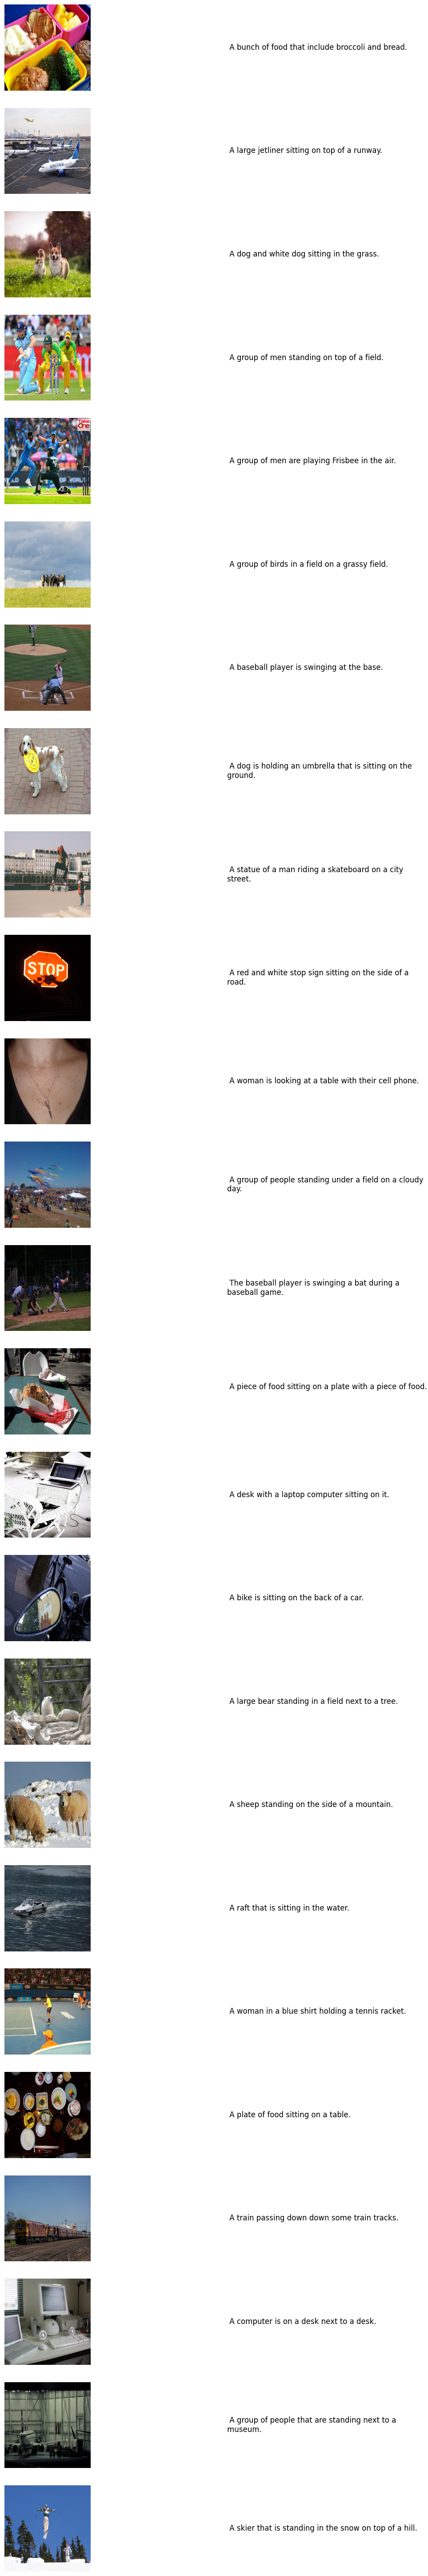

In [19]:
from dataset import load_image, SIZE
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def display_images_with_captions(image_paths, predictions, image_width=10, text_width=4):
    # Ensure we do not exceed the available images or predictions
    num_images = len(image_paths)

    # Dynamically adjust figure height based on the number of images
    fig_height = num_images * 3  # Scale height based on number of images
    fig = plt.figure(figsize=(image_width + text_width, fig_height))
    
    # Create a grid layout with minimal horizontal space
    grid = gridspec.GridSpec(num_images, 2, width_ratios=[image_width, text_width], wspace=0.05)

    for i in range(num_images):
        # Image subplot
        ax_image = plt.subplot(grid[i, 0])
        image = load_image(image_paths[i], size=dataset_config.get('image_size', SIZE), imagenet_normalize=False)
        ax_image.imshow(image)
        ax_image.axis("off")  # Hide axes for images

        # Text subplot
        ax_text = plt.subplot(grid[i, 1])
        ax_text.text(
            0, 0.5, predictions[i], fontsize=12, va='center', ha='left', wrap=True
        )
        ax_text.axis("off")  # Hide axes for text

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

# Example usage
display_images_with_captions(image_paths, captions)